iter:50 training loss: 0.005655215121805668, val loss: 0.005644708871841431
iter:100 training loss: 0.00451222388073802, val loss: 0.0044889082200825214
iter:150 training loss: 0.0044119409285485744, val loss: 0.004378297831863165
iter:200 training loss: 0.004072648007422686, val loss: 0.004058459307998419
iter:250 training loss: 0.004039911087602377, val loss: 0.003997073508799076
iter:300 training loss: 0.004017136059701443, val loss: 0.004028263036161661
iter:350 training loss: 0.00399736175313592, val loss: 0.003968857694417238
iter:400 training loss: 0.0039166598580777645, val loss: 0.004039158578962088
iter:450 training loss: 0.004006220493465662, val loss: 0.004014774225652218
iter:500 training loss: 0.003931745421141386, val loss: 0.004057186655700207
iter:550 training loss: 0.00396809633821249, val loss: 0.004000349901616573
iter:600 training loss: 0.0039396220818161964, val loss: 0.003955415450036526
iter:650 training loss: 0.003961814101785421, val loss: 0.003998687025159597

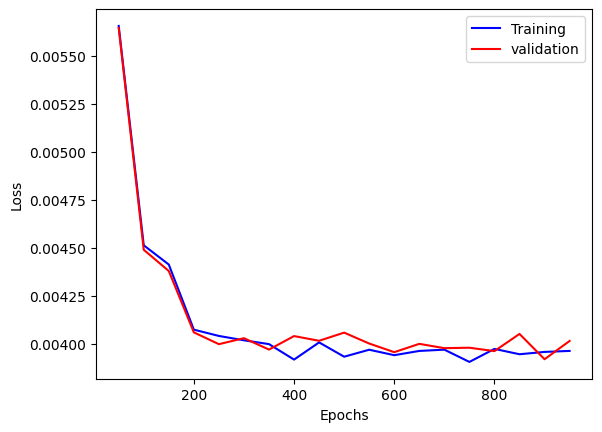

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import time
import numpy as np
import plotly.express as px


def visualise_tensor(data):
    data = data.detach().numpy()

    colormap = 'RdBu_r'
    fig = px.imshow(data, color_continuous_scale=colormap, zmin=-1, zmax=1)
    fig.show()
    fig.data = ()

weight_penalty_coefficient = 0.01

input_size = 20
hidden_layer_size= 5
output_size = input_size
learning_rate = 0.01
max_iters = 1000
dataset_size = 1024*32
sparsity = 0.1
batch_size = 32

decay_factor = 0.95
iters = []
loss_value = []
val_loss_value = []

imp_vector =torch.tensor([0.9**i for i in range(input_size)])



def get_l1_penalty():
    l1_penalty = 0
    for param in model.parameters():
        if param.requires_grad:
            l1_penalty += torch.norm(param, p=1)
    return l1_penalty

def sample_data():
    sparsity_vector = sparsity
    a, b = training_dataset.shape
    
    # Make sure sparsity_vector is a tensor and has the same device as training_dataset
    sparsity_vector = torch.tensor(sparsity_vector, device=training_dataset.device)
    
    # Reshape the sparsity vector to be broadcastable over the features dimension
    sparsity_vector = sparsity_vector.view(1, -1)
    
    # Create a sparsity matrix where each feature column has its corresponding sparsity
    sparsity_mat = torch.bernoulli(torch.full((a, b), 1.0) * sparsity_vector)
    
    X = training_dataset * sparsity_mat
    return X, X

def sample_validation_data():
    sparsity_vector = sparsity
    a, b = validation_dataset.shape
    
    # Make sure sparsity_vector is a tensor and has the same device as training_dataset
    sparsity_vector = torch.tensor(sparsity_vector, device=training_dataset.device)
    
    # Reshape the sparsity vector to be broadcastable over the features dimension
    sparsity_vector = sparsity_vector.view(1, -1)
    
    # Create a sparsity matrix where each feature column has its corresponding sparsity
    sparsity_mat = torch.bernoulli(torch.full((a, b), 1.0) * sparsity_vector)
    
    X = validation_dataset * sparsity_mat
    return X, X


def get_loss(target, output):
    loss = (imp_vector*((target-output)**2)).mean()
    return loss

def get_negative_weight_penalty():
    l1 = 0
    for layer in model.layers:
        l1+=torch.sum(F.relu(-layer.weight))
    return weight_penalty_coefficient*l1

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(input_size, hidden_layer_size, bias= False)
        self.decoder = nn.Linear(hidden_layer_size, output_size)
        self.layers = [self.encoder,self.decoder]

        self.decoder.weight.data = self.encoder.weight.data.t()

        self.relu = nn.ReLU()
    
    def forward(self, input, targets = None, return_hidden = False):
         
        hidden = self.encoder(input)
        final = self.decoder(hidden)
        logits = self.relu(final)

        loss = get_loss(targets, logits)
        return logits, loss, hidden
        

training_dataset = torch.rand(dataset_size, input_size)
validation_dataset = torch.rand(int(dataset_size/2), input_size)
output = input


model = Model()

LOAD_MODEL = False
PATH = "models/basic_linear_0.99.bin"
if LOAD_MODEL:
    model = Model()
    model.load_state_dict(torch.load(PATH))
    model.eval()
else:
    optimizer = torch.optim.Adam(model.parameters() , learning_rate, weight_decay= 1e-5)
    start_time = time.time()
    step_value = max_iters/20
    for i in range(1, max_iters):
        X, Y = sample_data()
        logits, loss = model(X, Y)
    
        if i%step_value ==0 :
            model.eval()
            with torch.no_grad():
                X_V,Y_V = sample_validation_data()
                _, val_loss = model(X_V, Y_V)
                iters.append(i)
                loss_value.append(loss.item())
                val_loss_value.append(val_loss.item())
                print(f"iter:{i} training loss: {loss.item()}, val loss: {val_loss.item()}")
            model.train()

        optimizer.zero_grad(set_to_none=True)
        #loss+= get_l1_penalty()
        loss.backward()
        optimizer.step()


    end_time = time.time()
    print(f"Took {end_time-start_time}s for {max_iters} epochs")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(iters,loss_value, color='blue', label="Training")
    plt.plot(iters, val_loss_value, "red", label = "validation")
    plt.legend()
    plt.show()

In [25]:
encoder_w = model.encoder.weight.data
decoder_w = model.decoder.weight.data

visualise_tensor(encoder_w.t())
# visualise_tensor(decoder_w.t())

visualise_tensor(decoder_w@encoder_w)
visualise_tensor(model.decoder.bias.data.reshape(-1,1))

In [9]:
x,y = sample_data()

In [26]:
data = torch.tensor([])
for i in range(10):
    x,y = sample_data()
    hidden = model(x, return_hidden = True)
    data = torch.cat((data,hidden))

torch.save(data, "data/hidden.pt")

In [11]:
a = torch.tensor([])

In [13]:
x.shape

torch.Size([32768, 20])

In [19]:
a = torch.cat((a,x))

In [15]:
a

tensor([])

In [20]:
a.shape

torch.Size([65536, 20])